## RELAX INC - Data Science Challenge

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work for.

# Predict Future User Adoption

Defining  an  "adopted  user" as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period, identify  which  factors  predict  future  user
adoption.

- Import packages

In [1]:
from scipy.stats import norm
from scipy.stats import t
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
#from pingouin import pairwise_ttests

## 1. Visualize users data

In [2]:
# read csv file
users = pd.read_csv('data/takehome_users.csv')
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# check info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
# update object_id to user_id
users = users.rename(columns={"object_id": "user_id"})

In [5]:
users['user_id'].nunique()

12000

- There are 12,000 users and 10 columns

## 2. Visualize engagement data

In [6]:
# read csv
engage_df = pd.read_csv('data/takehome_user_engagement.csv')
engage_df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [7]:
# check info
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
# check for number of unique user_id
engage_df['user_id'].nunique()

8823

- There are 207,917 logins and 8823 unique users. In order to facilitate analysis, time_stamp is transformed to datetime and set as the index.

In [9]:
# transform time_stamp to datetime 
engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])

# make time_stamp index
engage_df = engage_df.set_index('time_stamp')

In [10]:
# check for missing data and if time_stamp is datetime 
engage_df.isnull().sum()

user_id    0
visited    0
dtype: int64

## 3. Label adopted users

In [11]:
# add label to engage_df
def label_adopted(user_id):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    user_df = engage_df.loc[engage_df['user_id'] == user_id] #select out rows of this user
    user_df = user_df.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    
    for i in range(len(user_df) - 2): #loop over active days till the second to last day
        if user_df.index[i + 2] - user_df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            return 1
    return 0

In [12]:
# call function create column adopted_user in users
users['adopted_user'] = users['user_id'].apply(label_adopted)

In [13]:
# print number of adopted users
print('The platform has', users['adopted_user'].sum(), "active users, that's about",  
      (users['adopted_user'].sum()/len(users['adopted_user']))*100,'%', 'of total registered users.')

The platform has 1656 active users, that's about 13.8 % of total registered users.


In [14]:
# see users dataframe
users.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


## 4. Exploratory Data Analysis

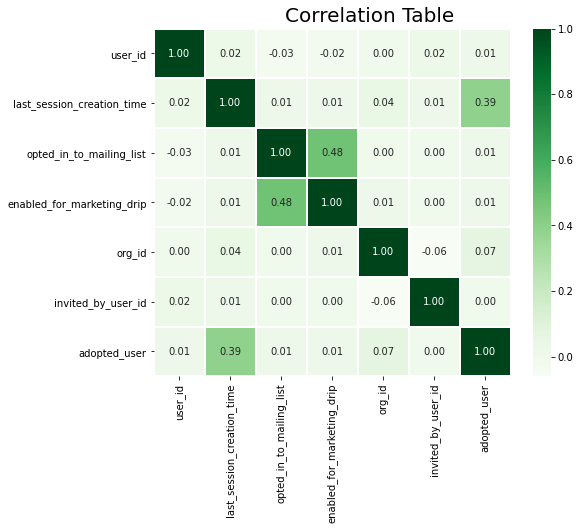

In [15]:
# Correlation table
corrmat = users.corr()
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="Greens",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Table', fontsize=20)

- The highest correlation with the target variable (adopted_user) is the feature variable last_session_creation_time. We can hypothesize that the age of the account may be a good predictor of adopted_user. This feature signifies the last login in linux timestamp. It's a good idea to transform it to a datetime object.

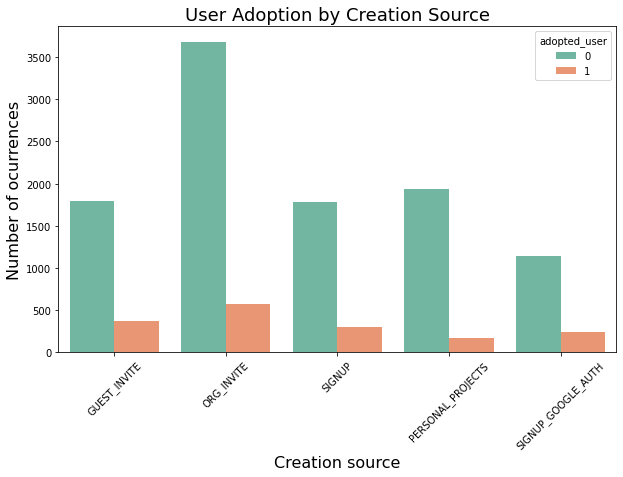

In [16]:
# Plot creation source and adopted user
plt.figure(figsize=(10,6))
_ = sns.countplot(x='creation_source', data=users, hue='adopted_user', palette='Set2')
_ = plt.xticks(rotation=45)
_ = plt.title('User Adoption by Creation Source', fontsize=18)
_ = plt.xlabel('Creation source', fontsize=16)
_ = plt.ylabel('Number of ocurrences', fontsize=16)


### 4. a. Hypothesis Testing
- Is there an association between creation source and adoption rate?

In [17]:
# Crosstab creation source and adopted user to test independence
crosstab = pd.crosstab(users['creation_source'], users['adopted_user']).T
crosstab

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted_user,,,,,
0,1794,3680,1939,1785,1146
1,369,574,172,302,239


In [18]:
# Apply chi2 to test if there's any association between different creation source and adoption
g, p, dof, expctd = chi2_contingency(crosstab)

print("p-value of Chi-square test for creation source vs. adopted/notadopted users =", p)

p-value of Chi-square test for creation source vs. adopted/notadopted users = 7.884346873316259e-19


- There is an association between the creation source and number of adopted users. However, here we are not looking at the difference between sources of creation and number of students who adopted the platform. We are also considering the number of users that did not adopt the platform. 
- Next, let's look only at adopted users vs creation source!

In [19]:
# Interested in the difference between creation source for adopted users only
adopted = crosstab.drop([0])
adopted

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted_user,,,,,
1,369,574,172,302,239


In [20]:
# Apply chi2 to test if there's any association between different creation source and adoption
g, p, dof, expctd = chi2_contingency(adopted)

print("p-value of Chi-square test for creation source vs. adopted user =", p)

p-value of Chi-square test for creation source vs. adopted user = 1.0


- There's no significant difference between the number of adopted users for each creation source.

### 4. b. Users adoption rate by creation source

In [21]:
# Adoption rate
users.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

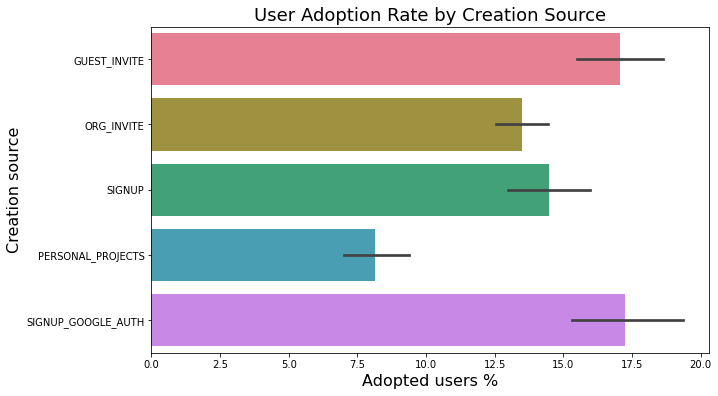

In [22]:
# Plot proportion of adopted users
plt.figure(figsize=(10,6))
sns.barplot(x='adopted_user', y='creation_source', data=users, 
            estimator=lambda x: sum(x==1)*100.0/len(x),  palette='husl')
_ = plt.title('User Adoption Rate by Creation Source', fontsize=18)
_ = plt.xlabel('Adopted users %', fontsize=16)
_ = plt.ylabel('Creation source', fontsize=16)

- The plot helps us visualize the difference between adoption rate per each one of the creation sources.
- We can use pairwise t-test to verify if there is one kind of sign-up (adoption source) that's statistically better than the others.

### 4. c. Pairwise t-test: is there a sigificant difference between the creation sources?

- Do users who sign up via certain sources more likely to become adopted users compared to other sources?

In [23]:
# Creat df with prporption to apply pairwise t-test
df1 = pd.DataFrame({"creation_source":["GUEST_INVITE", "ORG_INVITE ", 
                                       "PERSONAL_PROJECTS", "SIGNUP", "SIGNUP_GOOGLE_AUTH"],
                    "adoption_rate":[0.170596, 0.134932, 0.081478, 0.144705, 0.172563]})
df1

,creation_source,adoption_rate
0,GUEST_INVITE,0.170596
1,ORG_INVITE,0.134932
2,PERSONAL_PROJECTS,0.081478
3,SIGNUP,0.144705
4,SIGNUP_GOOGLE_AUTH,0.172563


In [24]:
# # Apply pairwise t-test
# pairwise_results = pairwise_ttests(dv='adoption_rate', between = ['creation_source'], tail='two-sided', data=df1)
# pairwise_results = pairwise_results[['A', 'B', 'p-unc']]
# pairwise_results = round(pairwise_results.sort_values(by=['p-unc'], ascending=False), 5)
# pairwise_results

## 5. Dealing with missing values

- Imputation

In [25]:
# check for missing data
users.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [26]:
# impute zero
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

# convert to datetime object
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# impute creation time for last_session_creation_time
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

## 6. Predictive Modeling

In [27]:
# Create dummy variable for creation source
creation_source = pd.get_dummies(users['creation_source'], drop_first=True)

# Concatenate dummies to users df
model_data = pd.concat([users, creation_source], axis=1).drop('creation_source', axis=1)

# Create target and features variables
y = model_data['adopted_user']
X = model_data.drop(['adopted_user', 'email', 'user_id', 'name', 'creation_time',
                     'invited_by_user_id', 'last_session_creation_time'], axis=1)

<AxesSubplot:title={'center':'Adopted user: target for prediction'}, xlabel='count', ylabel='adopted_user'>

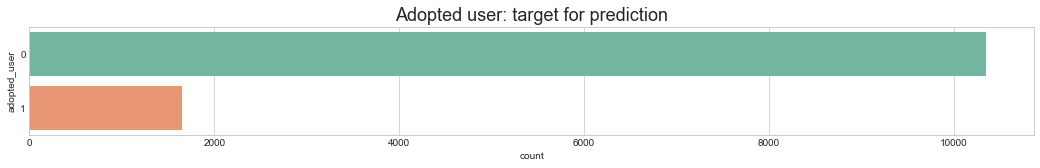

In [28]:
# target variable for prediction
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(18,2))
plt.title('Adopted user: target for prediction', fontsize=18)
sns.countplot(y='adopted_user', data=users, palette='Set2')

In [29]:
# Features
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0
1,0,0,1,1,0,0,0
2,0,0,94,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,193,0,0,0,0
...,...,...,...,...,...,...,...
11995,0,0,89,1,0,0,0
11996,0,0,200,0,0,0,1
11997,1,1,83,0,0,0,0
11998,0,0,6,0,1,0,0


In [30]:
# train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

### 6. a. Random Forest Classifier

In [31]:
# Use random forest model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)

print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 10}
Best average precision was 0.7344444444444445


In [32]:
# Apply best model
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=10
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.7226666666666667
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      2586
           1       0.16      0.23      0.19       414

    accuracy                           0.72      3000
   macro avg       0.51      0.52      0.51      3000
weighted avg       0.77      0.72      0.74      3000



In [33]:
# Feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

org_id                        0.940333
PERSONAL_PROJECTS             0.023968
opted_in_to_mailing_list      0.013162
enabled_for_marketing_drip    0.007578
SIGNUP_GOOGLE_AUTH            0.005541
SIGNUP                        0.005472
ORG_INVITE                    0.003946
dtype: float64


- Of the features included in the model, org_id seems to be the most important feature to predict adopted_user.
- Let's engineer some features using last session creation time which seemed to be the highest correlated feature with the target variables, adopted_user.

## 7. Feature Engineering

- Create feature called acct_age based on creation time and last login

In [34]:
# convert creation_time to date_time obj
users['creation_time'] = pd.to_datetime(users['creation_time'])

# convert to datetime object
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])


In [35]:
# subtract to find time active
users['acct_age'] = users['last_session_creation_time'] - users['creation_time']

# convert timedelta64[ns] to int
users['acct_age'] = users['acct_age'].dt.components.days

In [36]:
# check new column
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,acct_age
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,5


In [37]:
# user_invited = pd.DataFrame(users.invited_by_user_id.value_counts()).reset_index()
# user_invited.columns=['object_id', 'num_referrals']
# users = users.merge(user_invited, how='left', on='object_id')
# users['num_referrals'] = users['num_referrals'].fillna(0)

## 8. Reiterate Predictive Modeling

- Random Forest Classifier

In [38]:
# Create dummy variable for creation source
creation_source = pd.get_dummies(users['creation_source'], drop_first=True)

# Concatenate dummies to users df
model_data = pd.concat([users, creation_source], axis=1).drop('creation_source', axis=1)

# Create target and features variables
y = model_data['adopted_user']
X = model_data.drop(['adopted_user', 'email', 'user_id', 'name', 'creation_time',
                     'invited_by_user_id', 'last_session_creation_time'], axis=1)

In [39]:
# Features
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acct_age,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0,0
1,0,0,1,136,1,0,0,0
2,0,0,94,0,1,0,0,0
3,0,0,1,1,0,0,0,0
4,0,0,193,5,0,0,0,0
...,...,...,...,...,...,...,...,...
11995,0,0,89,0,1,0,0,0
11996,0,0,200,5,0,0,0,1
11997,1,1,83,0,0,0,0,0
11998,0,0,6,2,0,1,0,0


In [40]:
# train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [41]:
# Use random forest model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)

print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.9715555555555555


In [42]:
# Apply best model
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=50
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9636666666666667
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2586
           1       0.88      0.86      0.87       414

    accuracy                           0.96      3000
   macro avg       0.93      0.92      0.92      3000
weighted avg       0.96      0.96      0.96      3000



In [43]:
# Feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

acct_age                      0.910104
org_id                        0.069466
PERSONAL_PROJECTS             0.008877
opted_in_to_mailing_list      0.002852
enabled_for_marketing_drip    0.002323
SIGNUP                        0.002305
ORG_INVITE                    0.002241
SIGNUP_GOOGLE_AUTH            0.001832
dtype: float64


## 9. Conclusion

------